Epoch [20/200] | Loss D: 0.3576 | Loss G: 3.6582


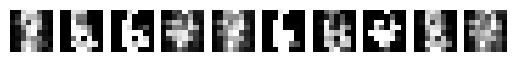

Epoch [40/200] | Loss D: 0.5126 | Loss G: 2.8244


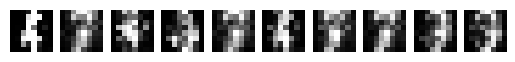

Epoch [60/200] | Loss D: 0.7776 | Loss G: 1.6900


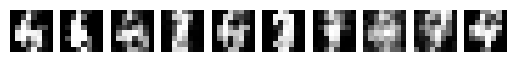

Epoch [80/200] | Loss D: 0.9924 | Loss G: 1.2734


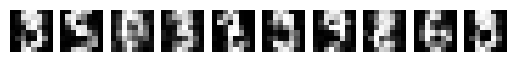

Epoch [100/200] | Loss D: 1.0859 | Loss G: 1.1423


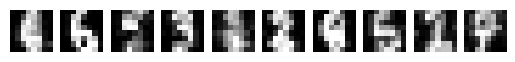

Epoch [120/200] | Loss D: 1.1441 | Loss G: 1.0898


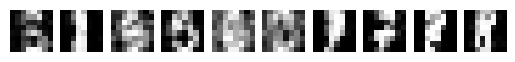

Epoch [140/200] | Loss D: 1.1427 | Loss G: 1.1023


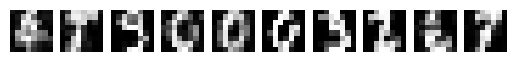

Epoch [160/200] | Loss D: 1.1402 | Loss G: 1.0605


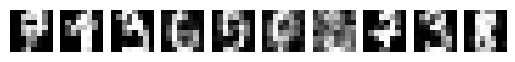

Epoch [180/200] | Loss D: 1.1734 | Loss G: 1.0425


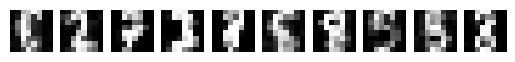

Epoch [200/200] | Loss D: 1.2028 | Loss G: 0.9960


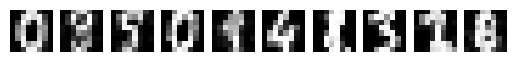

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Training parameters
EPOCHS = 200
DISPLAY_PER_EPOCHS = 20
BATCH_SIZE = 32

LATENT_DIM = 64
HIDDEN_DIM_A = 128
HIDDEN_DIM_B = 256

IMG_DIM = 64 # (8,8)の画像なので64に固定

# Load dataset
digits = load_digits()
X = digits.data / digits.data.max() *2-1 # Normalize pixel values between 0 and 1
y = digits.target

# Split dataset into training and test sets (80% train, 20% test)
X_train, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, img_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim1),
            # nn.BatchNorm1d(hidden_dim1), 
            
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            # nn.BatchNorm1d(hidden_dim2), 
            
            nn.ReLU(),
            nn.Linear(hidden_dim2, img_dim),  # Output size matches the image size (img_dim = 8x8 = 64)
            nn.Tanh()  # Assuming image pixel values are normalized between -1 and 1
        )

    def forward(self, x):
        return self.fc(x)
    


class Discriminator(nn.Module):
    def __init__(self, img_dim, hidden_dim1, hidden_dim2):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(img_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Initialize models
generator = Generator(latent_dim = LATENT_DIM, img_dim = IMG_DIM, hidden_dim1=HIDDEN_DIM_A, hidden_dim2=HIDDEN_DIM_B)
discriminator = Discriminator(img_dim = IMG_DIM, hidden_dim1=HIDDEN_DIM_B, hidden_dim2=HIDDEN_DIM_A)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# For plotting losses
losses_G = []
losses_D = []

# Training GAN
for epoch in range(EPOCHS):
    batch_G_loss = []
    batch_D_loss = []    
    for i in range(0, X_train.size(0), BATCH_SIZE):
        real_data = X_train[i:i + BATCH_SIZE]
        batch_size_real = real_data.size(0)
        
        # Labels for real and fake data
        valid = torch.ones(batch_size_real, 1)   # (バッチサイズ, 1)の配列。値は１
        fake = torch.zeros(batch_size_real, 1)  # (バッチサイズ, 1)の配列。値は0

        # Train Discriminator
        optimizer_D.zero_grad()

        # Generate fake data
        noise = torch.randn(batch_size_real, LATENT_DIM) # (バッチサイズ, LATENT_DIM)の配列,値は正規分布
        fake_data = generator(noise)

        # Discriminator loss on real and fake data
        real_loss = criterion(discriminator(real_data), valid) # real_dataはvalidに
        fake_loss = criterion(discriminator(fake_data.detach()), fake) # fake_dataはfakeとなるように最適化する。
        loss_D = real_loss + fake_loss
        batch_D_loss.append(loss_D.item())
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generator loss (Discriminator should predict that the fake data is real)
        loss_G = criterion(discriminator(fake_data), valid)
        batch_G_loss.append(loss_G.item())
        
        loss_G.backward()
        optimizer_G.step()

    losses_G.append(np.array(batch_G_loss).mean())
    losses_D.append(np.array(batch_D_loss).mean())

    # Display generated images during training (every 10 epochs)
    if (epoch + 1) % DISPLAY_PER_EPOCHS == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}] | Loss D: {losses_D[-1]:.4f} | Loss G: {losses_G[-1]:.4f}')
        generated_imgs = fake_data.view(-1, 8, 8).detach().numpy()
        for i in range(10):
            plt.subplot(1,10, i + 1)
            plt.imshow(generated_imgs[i], cmap='gray')
            plt.axis('off')
        plt.show()




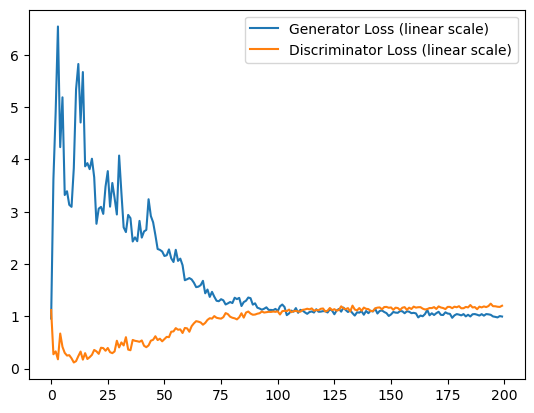

In [3]:
# Plot the loss values
LINEAR_SCALE=True

plt.figure()
if LINEAR_SCALE:
    plt.plot(losses_G, label='Generator Loss (linear scale)')
    plt.plot(losses_D, label='Discriminator Loss (linear scale)')
else:
    plt.plot(np.log(losses_G), label='Generator Loss (log scale)')
    plt.plot(np.log(losses_D), label='Discriminator Loss (log scale)')
plt.legend()
plt.show()